<a href="https://colab.research.google.com/github/costacis21/Brain-Tumor-Radiogenomic-Classification/blob/main/4-layer-2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-io==0.23.1
%tensorflow_version

!pip install kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp '/content/drive/MyDrive/Colab Notebooks/kaggle.json' ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install python3-wget
import wget
!pip install pydicom

In [4]:
#load data from keggle

!mkdir training

url="https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/29653/2420395/compressed/train.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1647612935&Signature=oNAv0GqLVKTd%2BTxvazMiadhu5Ra7J47M6BKcb%2Fdv2WK%2BN2X0GUpyktQwkGpvhBUKrnXiH42lryKsdNtb%2FiVT2%2BWu2hV07BdHYOCdwpKqhH%2FqMDOHzpHqwvJPn8QsibAkUxUiZVgw3V9K0AAM9ZQyFsnxf3QcOtIe2Dwn%2FfZE%2FcXBFcIYo0%2BUHja8OY9%2BnnKa0DPgbx2OEP8JhM97%2B2GriVE6DWNX3KAegZWuOEvZRutbvn5HOdzGf63xw9oxUW2Z4sMOgfv7bXhLPOI%2F9HbBpVORl66kI1LqHzsAhU2cItzixb5WY138kKjWuoOmswXxby0CZ1HvN%2Fo3YEFQ2LUmVw%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.zip"
wget.download(url,"training",bar=wget.bar_adaptive)
# !kaggle competitions download -p training/ -c "rsna-miccai-brain-tumor-radiogenomic-classification"

'training/train.zip'

In [ ]:
!kaggle -v

Kaggle API 1.5.12


In [6]:
!unzip training/train.zip -d training/

Streaming output truncated to the last 5000 lines.
  inflating: training/00838/T1wCE/Image-124.dcm  
  inflating: training/00838/T1wCE/Image-125.dcm  
  inflating: training/00838/T1wCE/Image-126.dcm  
  inflating: training/00838/T1wCE/Image-127.dcm  
  inflating: training/00838/T1wCE/Image-128.dcm  
  inflating: training/00838/T1wCE/Image-129.dcm  
  inflating: training/00838/T1wCE/Image-13.dcm  
  inflating: training/00838/T1wCE/Image-130.dcm  
  inflating: training/00838/T1wCE/Image-131.dcm  
  inflating: training/00838/T1wCE/Image-132.dcm  
  inflating: training/00838/T1wCE/Image-133.dcm  
  inflating: training/00838/T1wCE/Image-134.dcm  
  inflating: training/00838/T1wCE/Image-135.dcm  
  inflating: training/00838/T1wCE/Image-136.dcm  
  inflating: training/00838/T1wCE/Image-137.dcm  
  inflating: training/00838/T1wCE/Image-138.dcm  
  inflating: training/00838/T1wCE/Image-139.dcm  
  inflating: training/00838/T1wCE/Image-14.dcm  
  inflating: training/00838/T1wCE/Image-140.dcm  
 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import os
import glob

import pandas as pd
import numpy as np
from pathlib import Path

import random
from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback



import pydicom # Handle MRI images

import cv2  # OpenCV - https://docs.opencv.org/master/d6/d00/tutorial_py_root.html

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, precision_recall_curve,average_precision_score

from scipy import ndimage

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers

Text(0.5, 1.0, '0002-T2w-image-100')

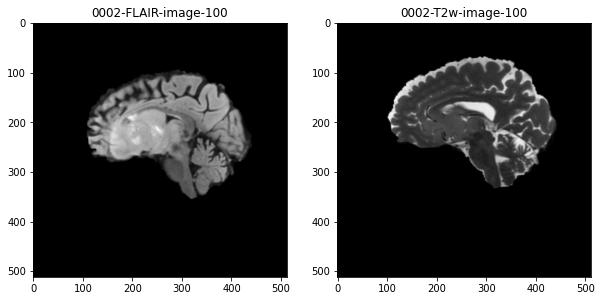

In [ ]:
#load two dcm files

image_bytes_1 = tf.io.read_file('training/00002/FLAIR/Image-450.dcm')
image_bytes_2 = tf.io.read_file('training/00002/T2w/Image-200.dcm')

image_1 = tfio.image.decode_dicom_image(image_bytes_1,dtype=tf.uint16)
image_2 = tfio.image.decode_dicom_image(image_bytes_2,dtype=tf.uint16)

fig,axes = plt.subplots(1,2,figsize=(10,10))
axes[0].imshow(np.squeeze(image_1.numpy()),cmap='gray')
axes[0].set_title('0002-FLAIR-image-100')
axes[1].imshow(np.squeeze(image_2.numpy()),cmap='gray')
axes[1].set_title('0002-T2w-image-100')


In [3]:
data_dir = Path('training')

#Read csv file for IDs
mri_types = ["FLAIR", "T1w", "T2w", "T1wCE"]
excluded_images = [109, 123, 709] # Bad images
train_df = pd.read_csv(data_dir / "_labels.csv")

#Remove images with unexpected issues
train_df = train_df[~train_df.BraTS21ID.isin(excluded_images)]

print(f"train data: Rows={train_df.shape[0]}, Columns={train_df.shape[1]}")


train data: Rows=582, Columns=2


In [4]:
def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=3)
    return img

def load_dicom(path, d_size= (128,128,64)):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return cv2.resize(data, dsize=d_size[:2])

def load_dicom2(path):
    data = np.concatenate([tf.expand_dims(pydicom.read_file(p).pixel_array, axis=-1) for p in path], axis=2)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return resize_volume(data)



In [5]:
def get_all_image_paths(brats21id, image_types, folder=''):
    # assert(image_type in mri_types)
    patient_path = os.path.join(folder,
                str(brats21id).zfill(5)
    )
    
    paths=[]
    for mri_type in image_types:
      paths += sorted(
          glob.glob(os.path.join(patient_path, mri_type, "*"))
      )

    num_images = len(paths)
    start = int(num_images * 0.25)
    end = int(num_images * 0.75)

    interval = 1
    
    return np.array(paths[start:end:interval])

def get_all_images(brats21id, image_types, folder=''):
    return [load_dicom(path) for path in get_all_image_paths(brats21id, image_types, folder)]

def get_all_images2(brats21id, image_type, folder=''):
    return [load_dicom2(get_all_image_paths(brats21id, image_type, folder))]

def get_all_data_for_train(mri_type):
    global train_df
    
    X = []
    y = []
    train_ids = []
    images=[]

    for i in tqdm(train_df.index):
        x = train_df.loc[i]
        
        images = get_all_images(brats21id=int(x['BraTS21ID']), image_types=mri_type, folder='training/')
        
        label = x['MGMT_value']

        X += images
        y += [label] * len(images)
        train_ids += [int(x['BraTS21ID'])] * len(images)
        assert(len(X) == len(y))
    return np.array(X), np.array(y), np.array(train_ids)

In [ ]:

from skimage import morphology
##Pre processing


def remove_noise(image, display=False):
    
    
    brain_image = image
    
    segmentation = morphology.dilation(brain_image, np.ones((1, 1)))
    labels, label_nb = ndimage.label(segmentation)
    
    label_count = np.bincount(labels.ravel().astype(np.int))
    label_count[0] = 0

    mask = labels == label_count.argmax()
 
    mask = morphology.dilation(mask, np.ones((1, 1)))
    mask = ndimage.morphology.binary_fill_holes(mask)
    mask = morphology.dilation(mask, np.ones((3, 3)))
    masked_image = mask * brain_image
    return masked_image

def crop_image(image,display=None):
  mask=image=1

  coords= np.array(np.nonzero(~mask))
  top_left=np.min(coords,axis=1)
  bottom_right = np.max(coords,axis=1)

  croped_image=image[top_left[0]:bottom_right[0],top_left[1]:bottom_right[1]]

  return croped_image

In [6]:
X_FLAIR,y_FLAIR,trainidt_FLAIR=get_all_data_for_train(["FLAIR"])
# X_FLAIR_T2w,y_FLAIR_T2w,trainidt_FLAIR_T2w=get_all_data_for_train(["FLAIR","T2w"])

X_T1W,y_T1W,trainidt_T1W=get_all_data_for_train(["T1w"])
X_T1WCE,y_T1WCE,trainidt_T1WCE=get_all_data_for_train(["T1wCE"])
X_T2W,y_T2W,trainidt_T2W=get_all_data_for_train(["T2w"])
X_all,y_all,trainidt_all = get_all_data_for_train(mri_types)





  0%|          | 0/582 [00:00<?, ?it/s]

  0%|          | 0/582 [00:00<?, ?it/s]

  0%|          | 0/582 [00:00<?, ?it/s]

  0%|          | 0/582 [00:00<?, ?it/s]

  0%|          | 0/582 [00:00<?, ?it/s]

In [13]:
# print(f"X_FLAIR_T2w: {X_FLAIR_T2w.shape}\t X_FLAIR: {X_FLAIR.shape}\t X_T2w: {X_T2W.shape}")
def load_mri_type(mri_type):
  global X, y, trainidt

  if type(mri_type)==list:
    X,y,trainidt = X_all,y_all,trainidt_all
  # if mri_type =="FLAIR_T2w":   
  #   X,y,trainidt = X_FLAIR_T2w,y_FLAIR_T2w,trainidt_FLAIR_T2w
  if mri_type =="FLAIR":   
    X,y,trainidt = X_FLAIR,y_FLAIR,trainidt_FLAIR
  if mri_type =="T1w":   
    X,y,trainidt = X_T1W,y_T1W,trainidt_T1W
  if mri_type =="T1wCE":   
    X,y,trainidt = X_T1WCE,y_T1WCE,trainidt_T1WCE
  if mri_type =="T2w":   
    X,y,trainidt = X_T2W,y_T2W,trainidt_T2W

load_mri_type(mri_types)

(173633, 128, 128)
3
0


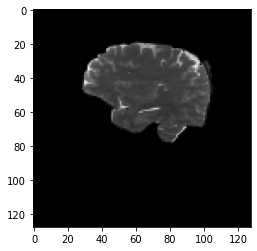

In [100]:
print(X.shape)
print(trainidt[1000])
print(y[1000])


plt.figure()
plt.imshow(np.squeeze(X[1000]),cmap="gray")

In [ ]:
def get_3DCNNmodel(width=128, height=128, depth=64, name='3dcnn'):
    """Build a 3D convolutional neural network model."""

    inputs = tf.keras.Input((width, height, depth, 1))

    x = tf.keras.layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    # x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    # x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv3D(filters=128, kernel_size=5, activation="relu")(x)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv3D(filters=256, kernel_size=5, activation="relu")(x)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.GlobalAveragePooling3D()(x)
    x = tf.keras.layers.Dense(units=512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    output = keras.layers.Dense(2, activation="sigmoid")(x)

 
    model = keras.Model(inputs, output)
    initial_learning_rate =  0.0004
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=100000,
        decay_rate=0.96, 
        staircase=True
    )
  
    roc_auc = tf.keras.metrics.AUC(name='roc_auc', curve='ROC')

    model.compile(
        loss="binary_crossentropy", 
        optimizer=keras.optimizers.Adam(),
        metrics=[roc_auc],
    )
    return model

In [ ]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr



def get_3DCNNmodel2(width=128, height=128, depth=64, name='3dcnn'):##edited
    """Build a 3D convolutional neural network model."""
    w_init=tf.keras.initializers.HeNormal()

    inputs = tf.keras.Input(shape=(width, height, depth, 1))
  
    x= tf.keras.layers.Conv3D(filters=64,kernel_size=5,)(inputs)
    x = tf.keras.layers.Dropout(0.5)(x)
    x= tf.keras.layers.MaxPool3D(pool_size=2)(x)

    x= tf.keras.layers.Conv3D(filters=64,kernel_size=5)(inputs)
    x= tf.keras.layers.MaxPool3D(pool_size=2)(x)

    x = tf.keras.layers.Conv3D(filters=128, kernel_size=5 ,activation="relu",padding='same')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)


    x = tf.keras.layers.Conv3D(filters=256, kernel_size=3,activation="relu",padding='same')(x)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)


    x = tf.keras.layers.Conv3D(filters=512, kernel_size=3, activation="relu",padding='same')(x)
    x = tf.keras.layers.MaxPool3D(pool_size=4)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Dropout(0.2)(x)


  


    x = tf.keras.layers.GlobalAveragePooling3D()(x)
    x = tf.keras.layers.Dense(units=1024, activation="relu")(x)
    # x = tf.keras.layers.Dropout(0.3)(x)

    output = keras.layers.Dense(2, activation="sigmoid")(x)

 
    model = keras.Model(inputs, output)
    initial_learning_rate =  0.01
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=82,
        decay_rate=0.80, 
        staircase=True
    )
  
    roc_auc = tf.keras.metrics.AUC(name='roc_auc', curve='ROC')
    optimiser=keras.optimizers.Adam(lr_schedule)
    lr_metric = get_lr_metric(optimiser)
    model.compile(
        loss="binary_crossentropy", 
        optimizer=optimiser,
        metrics=[roc_auc],
    )
    return model

In [15]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr



def get_2DCNNmodel(width=128, height=128, depth=64, name='3dcnn'):##edited
    """Build a 2D convolutional neural network model."""
    w_init=tf.keras.initializers.HeNormal()

    inputs = tf.keras.Input(shape=(width, height, 1))
  
    x= tf.keras.layers.Conv2D(filters=64,kernel_size=5,)(inputs)
    x = tf.keras.layers.Dropout(0.5)(x)
    x= tf.keras.layers.MaxPool2D(pool_size=2)(x)

    x= tf.keras.layers.Conv2D(filters=64,kernel_size=5)(inputs)
    x= tf.keras.layers.MaxPool2D(pool_size=2)(x)

    x = tf.keras.layers.Conv2D(filters=128, kernel_size=5 ,activation="relu",padding='same')(x)
    # x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)


    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3,activation="relu",padding='same')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Dropout(0.5)(x)


    x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, activation="relu",padding='same')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=4)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Dropout(0.2)(x)


  


    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(units=1024, activation="relu")(x)
    x = tf.keras.layers.Dense(units=3072, activation="relu")(x)
  

    output = keras.layers.Dense(1, activation="sigmoid")(x)

 
    model = keras.Model(inputs, output)
    initial_learning_rate =  0.01
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=100,
        decay_rate=0.95, 
        staircase=True
    )
  
    roc_auc = tf.keras.metrics.AUC(name='roc_auc', curve='ROC')
    pr_auc = tf.keras.metrics.AUC(name='pr_auc', curve='PR')

    optimiser=keras.optimizers.Adam(learning_rate=initial_learning_rate)#lr_schedule
    lr_metric = get_lr_metric(optimiser)
    model.compile(
        loss="binary_crossentropy", 
        optimizer=optimiser,
        metrics=[roc_auc,pr_auc],
    )
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      1664      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 128)       204928    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 128)      0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 31, 31, 128)      512   

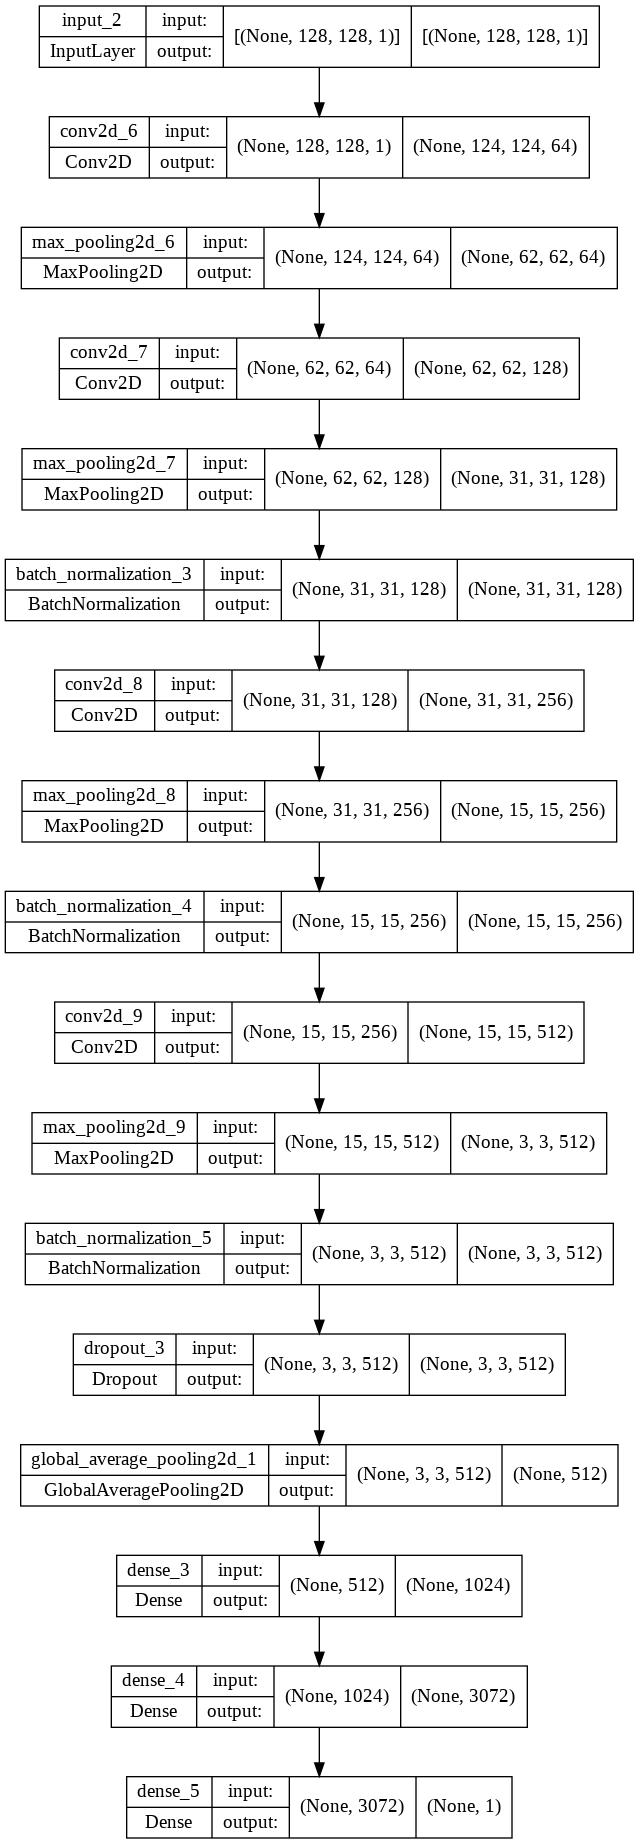

In [8]:
from keras.utils.vis_utils import plot_model
print(get_2DCNNmodel().summary())
plot_model(get_2DCNNmodel() ,to_file='model_plot.png' , show_shapes=True, show_layer_names=True)

In [ ]:
""" 
function ConnectButton(){
  console.log("Connect pushed"); 
  document.querySelector("#top-toolbar > colab-connectbutton").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);
"""

' \nfunction ConnectButton(){\n  console.log("Connect pushed"); \n  document.querySelector("#top-toolbar > colab-connectbutton").shadowRoot.querySelector("#connect").click() \n}\nsetInterval(ConnectButton,60000);\n'

In [9]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode='min', patience=13)
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='auto',factor=0.4, patience=4, min_lr=0.000005)

###patience=20



(173633, 128, 128)
Epoch 1/100
394/394 - 201s - loss: 1.0287 - roc_auc: 0.5377 - pr_auc: 0.5885 - val_loss: 0.6801 - val_roc_auc: 0.5621 - val_pr_auc: 0.6184 - lr: 0.0100 - 201s/epoch - 511ms/step
Epoch 2/100
394/394 - 158s - loss: 0.6786 - roc_auc: 0.5690 - pr_auc: 0.6188 - val_loss: 0.6788 - val_roc_auc: 0.5620 - val_pr_auc: 0.6173 - lr: 0.0100 - 158s/epoch - 400ms/step
Epoch 3/100
394/394 - 158s - loss: 0.6760 - roc_auc: 0.5790 - pr_auc: 0.6319 - val_loss: 0.6756 - val_roc_auc: 0.5742 - val_pr_auc: 0.6354 - lr: 0.0100 - 158s/epoch - 402ms/step
Epoch 4/100
394/394 - 158s - loss: 0.6723 - roc_auc: 0.5878 - pr_auc: 0.6495 - val_loss: 0.6710 - val_roc_auc: 0.5857 - val_pr_auc: 0.6534 - lr: 0.0100 - 158s/epoch - 402ms/step
Epoch 5/100
394/394 - 160s - loss: 0.6664 - roc_auc: 0.5951 - pr_auc: 0.6637 - val_loss: 0.7021 - val_roc_auc: 0.5833 - val_pr_auc: 0.6536 - lr: 0.0100 - 160s/epoch - 407ms/step
Epoch 6/100
394/394 - 160s - loss: 0.6501 - roc_auc: 0.6266 - pr_auc: 0.6977 - val_loss: 0.

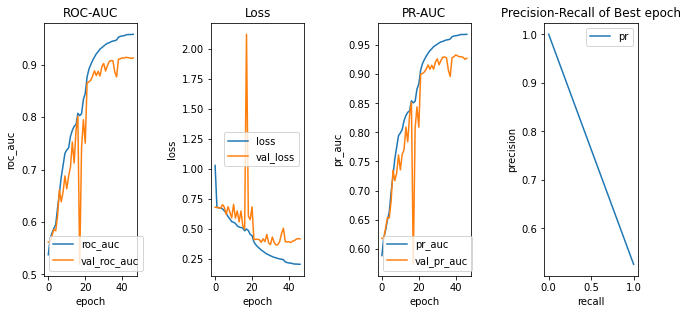

Dataset contains: w/MGMT=307 w/oMGMT=278
Test scores:
 ROC-AUC-score=0.5	 Normalised-ROC-AUC-score=0.5	 PR-score=0.5257731958762887	 Accuracy=0.4742268041237113	 Loss=18.159562846808708 


 -----------------------------------------------------------------------------------------------


NameError: ignored

In [14]:


# best_auc = float("-inf")
# pr_auc = float("-inf")

# round1_mri_type=mri_types[0] #["FLAIR", "T1w", "T2w", "T1wCE"]
# mri_type=mri_types[3]
# model=tf.keras.models.load_model(filepath=f"/content/drive/MyDrive/Colab Notebooks/models/best/2d_best_modelv2.0_T2w.h5")

# mri_types=["FLAIR", "T1w", "T2w" , "T1wCE", "FLAIR_T2w"]
# for d,mri_type in enumerate(mri_types[4:]):
    # if(mri_type == round1_mri_type):
    #     print("SKIPPING: "+mri_type)
    #     continue

    # print("LOADING: "+mri_type)

num_of_tries=4
    
load_mri_type(mri_types)
print(X.shape)
for i in (range(num_of_tries)):
    model_name=f"2d_best_modelv5.{i}_all.h5"
    # commit with test variables
    checkpoint_filepath = f"drive/MyDrive/Colab Notebooks/models/best/2d models/{model_name}"

    model = get_2DCNNmodel()
    model_checkpoint1_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        mode="max",
        monitor="roc_auc",
        save_best_only=True,
        save_freq=num_of_tries,
        verbose=0,
    )


    X_train, X_valid, y_train, y_valid, trainidt_train, trainidt_valid = \
    train_test_split(X, y, trainidt, test_size=0.2, random_state=i)


    X_train, X_test, y_train, y_test, trainidt_train, trainidt_test = \
    train_test_split(X_train, y_train, trainidt_train, test_size=0.15, random_state=i)


    X_train = tf.expand_dims(X_train, axis=-1)
    X_valid = tf.expand_dims(X_valid, axis=-1)
    X_test = tf.expand_dims(X_test, axis=-1)
    # y_train = to_categorical(y_train)
    # y_valid = to_categorical(y_valid)
    # y_test = to_categorical(y_test)
    

    

    # 582*0.2 = 465 mod 1, 3, 5, 15, 31, 93, 155, 465 =0

    

    history = model.fit(x=X_train,y=y_train, epochs=100, batch_size = 300,\
                        callbacks=[model_checkpoint1_cb, early_stopping_cb,reduce_lr_cb],\
                        validation_data=(X_valid, y_valid), verbose=2)
  



    model_best = tf.keras.models.load_model(filepath=checkpoint_filepath)
    y_pred = model_best.predict(X_test,batch_size = 2)

    pred = np.argmax(y_pred, axis=1)

    result = pd.DataFrame(trainidt_test)
    result[1] = pred

    result.columns = ["BraTS21ID", "MGMT_value"]
    result2 = result.groupby("BraTS21ID", as_index=False).mean()

    result2 = result2.merge(train_df, on="BraTS21ID")
    

    show_stats(history,result2,checkpoint_filepath)
    

    

        


# TODO input > convolud&maxpool -> dense (decode) >  encode >classify

In [10]:
def show_stats(history,result2,model_name):
  print(" -----------------------------------------------------------------------------------------------\n\n")

  roc_auc_scoreT = roc_auc_score(
    result2.MGMT_value_y,
    result2.MGMT_value_x)

  pr_score= average_precision_score(
      result2.MGMT_value_y,
      result2.MGMT_value_x,)

  precision,recall,threshold = precision_recall_curve(
      result2.MGMT_value_y,
      result2.MGMT_value_x,)

  accuracy = accuracy_score(
      result2.MGMT_value_y,
      result2.MGMT_value_x >= 0.5,)

  loss = log_loss(
      result2.MGMT_value_y,
      result2.MGMT_value_x,)

  roc_auc_normalised = roc_auc_score(
      result2.MGMT_value_y,
      result2.MGMT_value_x >= 0.5)

  show_graphs(history,recall,precision,model_name)
  print(f"Test scores:\n ROC-AUC-score={roc_auc_scoreT}\t Normalised-ROC-AUC-score={roc_auc_normalised}\t PR-score={pr_score}\t Accuracy={accuracy}\t Loss={loss} ")

  print("\n\n -----------------------------------------------------------------------------------------------")
  

In [11]:
def show_graphs(history,recall,precision,model_name):
  fig , axes= plt.subplots(nrows=1, ncols=4)

  fig.set_size_inches(w=10,h=5)
  axes[0].plot(history.history['roc_auc'])
  axes[0].plot(history.history['val_roc_auc'])
  axes[0].set_xlabel("epoch")
  axes[0].set_ylabel("roc_auc")
  axes[0].legend(["roc_auc","val_roc_auc"],loc="best")
  axes[0].set_title("ROC-AUC")

  axes[1].plot(history.history['loss'])
  axes[1].plot(history.history['val_loss'])
  axes[1].set_xlabel("epoch")
  axes[1].set_ylabel("loss")
  axes[1].legend(["loss","val_loss"],loc="best")
  axes[1].set_title("Loss")



  axes[2].plot(history.history['pr_auc'])
  axes[2].plot(history.history['val_pr_auc'])
  axes[2].set_xlabel( "epoch")
  axes[2].set_ylabel("pr_auc")
  axes[2].legend(["pr_auc","val_pr_auc"],loc="best")
  axes[2].set_title("PR-AUC")
  
  axes[3].plot(recall,precision)
  axes[3].set_xlabel( "recall")
  axes[3].set_ylabel("precision")
  axes[3].legend(["pr","val_pr_a"],loc="best")
  axes[3].set_title("Precision-Recall of Best epoch")
  

  fig.tight_layout(pad=3)
  
  plt.savefig(f'{model_name}.png')
  plt.show(fig,axes)
  print("Dataset contains: w/MGMT=307 w/oMGMT=278")


KeyboardInterrupt: ignored

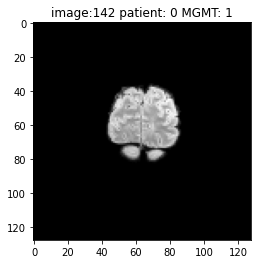

In [112]:
%matplotlib inline
from IPython import display
from time import sleep
# plt.ion()
fig, ax=plt.subplots(nrows=1,ncols=1)
# print(X_test[0,0,0,:][0])
# print(X_test[:,:,:,0].shape)

for i,image in enumerate(X):
  # print(image.shape)
  ax.imshow(np.squeeze(image),cmap='gray')
  ax.set_title(f"image:{i} patient: {trainidt[i]} MGMT: {y[i]}")
  fig.show()
  display.clear_output(wait=True)
  display.display(plt.gcf())
  sleep(0.1)

  


['FLAIR', 'T1w', 'T2w', 'T1wCE']
174/174 [==============================] - 8s 45ms/step
 -----------------------------------------------------------------------------------------------




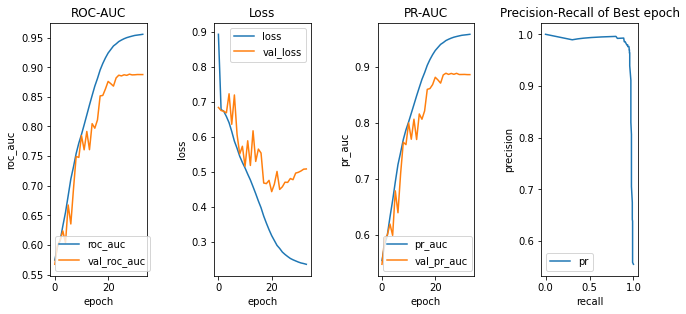

Dataset contains: w/MGMT=307 w/oMGMT=278
Test scores:
 ROC-AUC-score=0.9773787534337406	 Normalised-ROC-AUC-score=0.9327578857630009	 PR-score=0.9803404336695503	 Accuracy=0.9347079037800687	 Loss=0.3304659989493789 


 -----------------------------------------------------------------------------------------------
174/174 [==============================] - 7s 38ms/step
 -----------------------------------------------------------------------------------------------




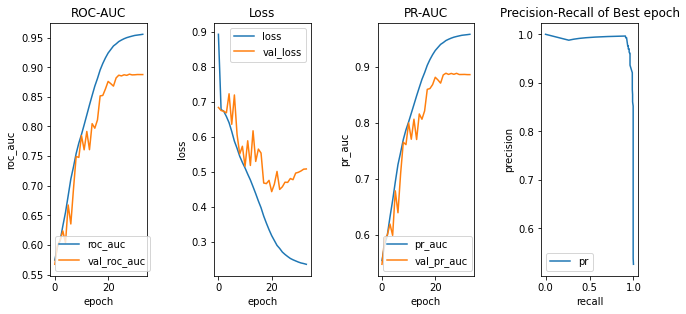

Dataset contains: w/MGMT=307 w/oMGMT=278
Test scores:
 ROC-AUC-score=0.988917306052856	 Normalised-ROC-AUC-score=0.9463626030122194	 PR-score=0.9865671921457712	 Accuracy=0.9484536082474226	 Loss=0.3784013307769146 


 -----------------------------------------------------------------------------------------------
174/174 [==============================] - 7s 38ms/step
 -----------------------------------------------------------------------------------------------




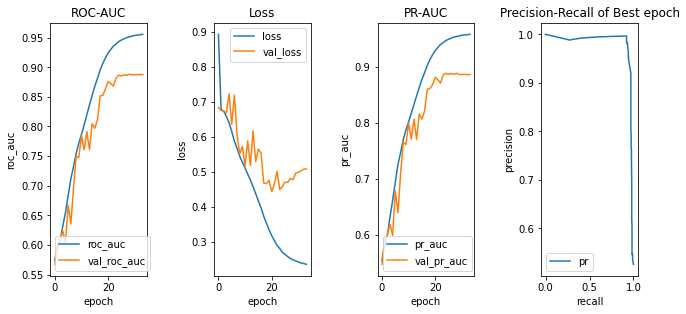

Dataset contains: w/MGMT=307 w/oMGMT=278
Test scores:
 ROC-AUC-score=0.9733056265984652	 Normalised-ROC-AUC-score=0.9381926683716966	 PR-score=0.9788022520710342	 Accuracy=0.9398625429553265	 Loss=0.49882517942112564 


 -----------------------------------------------------------------------------------------------
174/174 [==============================] - 7s 38ms/step
 -----------------------------------------------------------------------------------------------




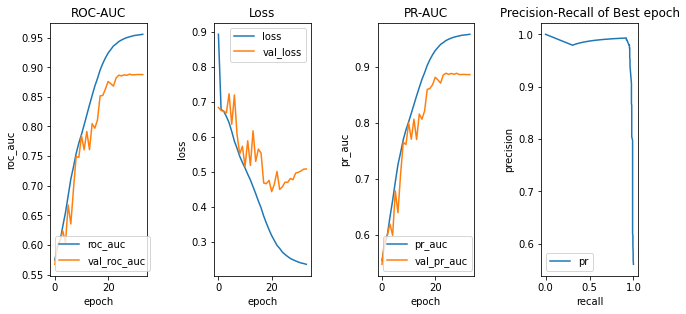

Dataset contains: w/MGMT=307 w/oMGMT=278
Test scores:
 ROC-AUC-score=0.9813512361466326	 Normalised-ROC-AUC-score=0.9324026712134128	 PR-score=0.9776658417272406	 Accuracy=0.9347079037800687	 Loss=0.3813388413338056 


 -----------------------------------------------------------------------------------------------
174/174 [==============================] - 7s 38ms/step
 -----------------------------------------------------------------------------------------------




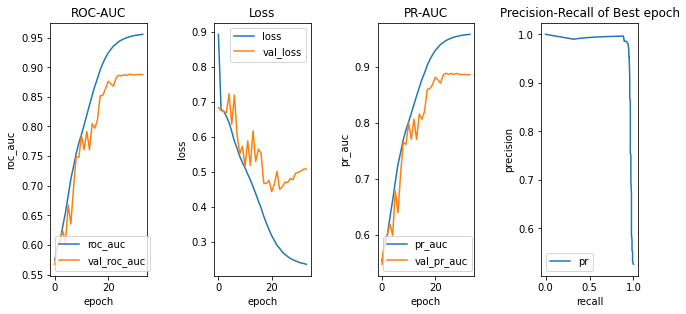

Dataset contains: w/MGMT=307 w/oMGMT=278
Test scores:
 ROC-AUC-score=0.968421426541631	 Normalised-ROC-AUC-score=0.9280335322534812	 PR-score=0.9765735310910548	 Accuracy=0.929553264604811	 Loss=0.5072821782993158 


 -----------------------------------------------------------------------------------------------


In [121]:
# for mri_type in mri_types:
#   print(f"trained 2d FLAIR on {mri_type}")
print(mri_types)
load_mri_type(mri_types)
for i in range(5):

  X_train, X_test, y_train, y_test, trainidt_train, trainidt_test = \
          train_test_split(X, y, trainidt, test_size=0.1,shuffle=True)
  path="/content/drive/MyDrive/Colab Notebooks/models/best/2d models/2d_best_modelv3.1_all.h5"
  model_best = tf.keras.models.load_model(filepath="/content/drive/MyDrive/Colab Notebooks/models/best/2d models/2d_best_modelv3.1_all.h5")
  y_pred = model_best.predict(X_test,verbose=1,batch_size=100)

  pred = np.argmax(y_pred, axis=1)

  result = pd.DataFrame(trainidt_test)
  result[1] = pred

  result.columns = ["BraTS21ID", "MGMT_value"]
  result2 = result.groupby("BraTS21ID", as_index=False).mean()

  result2 = result2.merge(train_df, on="BraTS21ID")

  show_stats(history,result2,path)
  